<a href="https://colab.research.google.com/github/azhow/Discriminative-Loss-Study/blob/main/CVPPP_Discriminative_Loss_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
!pip install -U segmentation-models-pytorch > /dev/null

In [ ]:
import os
import random
import torch
import glob
import datetime
import shutil

import numpy as np
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset, Dataset
from torch.nn.modules.loss import _Loss
from torch.autograd import Variable
from torchvision.transforms import functional as F

from PIL import Image
from sklearn.model_selection import train_test_split
from google.colab import drive
from google.colab import files
from copy import deepcopy
from torch import autograd
from tqdm.notebook import tqdm
from pathlib import Path
from sklearn.cluster import KMeans, MeanShift

%matplotlib inline

## CVPPP 2017 LSC Dataset

In [ ]:
# Create custom transforms to apply the same random transform to input and masks
class Resize(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, sem, colored = sample['image'], sample['sem'], sample['colored']

        image = F.resize(image, self.output_size, interpolation=T.InterpolationMode.NEAREST)
        sem = F.resize(sem, self.output_size, interpolation=T.InterpolationMode.NEAREST)
        colored = F.resize(colored, self.output_size, interpolation=T.InterpolationMode.NEAREST)

        return {'image': image, 'sem': sem, 'colored': colored}

class RandomRotation(object):
    def __call__(self, sample):
        image, sem, colored = sample['image'], sample['sem'], sample['colored']

        angle = random.randint(0, 360)

        image = F.rotate(image, angle, interpolation=T.InterpolationMode.NEAREST)
        sem = F.rotate(sem, angle, interpolation=T.InterpolationMode.NEAREST)
        colored = F.rotate(colored, angle, interpolation=T.InterpolationMode.NEAREST)

        return {'image': image, 'sem': sem, 'colored': colored}

class RandomScaleDeformation(object):
    def __init__(self, max_x_deformation, max_y_deformation):
        self.x_deform = max_x_deformation
        self.y_deform = max_y_deformation

    def __call__(self, sample):
        image, sem, colored = sample['image'], sample['sem'], sample['colored']

        original_y_size = image.size[0]
        original_x_size = image.size[1]

        y_size = int(random.uniform(1, self.y_deform) * image.size[0])
        x_size = int(random.uniform(1, self.x_deform) * image.size[1])

        image = F.resize(image, (y_size, x_size), interpolation=T.InterpolationMode.NEAREST)
        sem = F.resize(sem, (y_size, x_size), interpolation=T.InterpolationMode.NEAREST)
        colored = F.resize(colored, (y_size, x_size), interpolation=T.InterpolationMode.NEAREST)

        # If image is bigger in any dimension we should crop it to the original size
        if (y_size > original_y_size) or (x_size > original_x_size):
            # Difference to the desired size
            y_offset = random.randint(0, y_size - original_y_size)
            x_offset = random.randint(0, x_size - original_x_size)

            image = F.crop(image, y_offset, x_offset, original_y_size, original_x_size)
            sem = F.crop(sem, y_offset, x_offset, original_y_size, original_x_size)
            colored = F.crop(colored, y_offset, x_offset, original_y_size, original_x_size)
    
        assert image.size[0] == original_y_size, "Image lost dimension size"
        assert image.size[1] == original_x_size, "Image lost dimension size"

        return {'image': image, 'sem': sem, 'colored': colored}

class RandomHFlip(object):
    def __call__(self, sample):
        image, sem, colored = sample['image'], sample['sem'], sample['colored']

        choice = random.choice([True, False])

        if choice:
            image = F.hflip(image)
            sem = F.hflip(sem)
            colored = F.hflip(colored)

        return {'image': image, 'sem': sem, 'colored': colored}

class ToTensor(object):
    def __call__(self, sample):
        image, sem, colored = sample['image'], sample['sem'], sample['colored']

        image = F.to_tensor(image)

        return {'image': image, 'sem': sem, 'colored': colored}

class Last(object):
    def __init__(self, mean=None, std=None):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        image, sem, colored = sample['image'], sample['sem'], sample['colored']

        # Normalize input
        if self.mean is not None and self.std is not None:
            image = F.normalize(image, self.mean, self.std)

        # Create two channeled image for semantic mask
        sem = self._build_semantic_mask(sem)

        # Create instance map
        ins = self._build_instance_map(colored)

        # Only now we can transform it to tensor
        colored = F.to_tensor(colored)

        # Transpose and transform to tensor (cant normalize these)
        sem = torch.Tensor(np.transpose(sem, [2, 0, 1]))
        ins = torch.Tensor(np.transpose(ins, [2, 0, 1]))
        
        return {'image': image, 'sem': sem, 'ins': ins, 'colored': colored}

    def _build_instance_map(self, instance_labels_im):
        # num_samples x h x w x num_classes
        GT_COLORS = instance_labels_im.getcolors()
        pixel_count = np.sum([x[0] for x in GT_COLORS])
        assert pixel_count == (instance_labels_im.size[0] * instance_labels_im.size[1]), "Mismatch in mapping labels to pixels"
        instance_labels_im = np.array(instance_labels_im)

        instance_map = np.zeros((instance_labels_im.shape[0], instance_labels_im.shape[1], 1), dtype=np.uint8)
        color_idx = 1

        for count, color in GT_COLORS:
            if color != (0, 0, 0):
                indices = np.where(np.all(instance_labels_im == color, axis=-1))

                if len(indices[0]) > 0:
                    instance_map[indices] = color_idx
                    color_idx += 1

        assert color_idx - 1 == len(GT_COLORS) - 1,\
         f"Failure creating instance map. Not all colors were found on image ({color_idx - 1}x{len(GT_COLORS) - 1})."

        return instance_map

    def _build_semantic_mask(self, semantic_mask_im):
        semantic_mask_im = np.array(semantic_mask_im)
        mask = np.zeros((semantic_mask_im.shape[0], semantic_mask_im.shape[1], 2), dtype=np.float32)
        mask[:, :, 0] = semantic_mask_im == 0
        mask[:, :, 1] = semantic_mask_im != 0

        return mask

class CVPPPDataset(Dataset):
    def __init__(self, root_dir, train_length_factor=3):
        """
        Creates an instance of the CVPPP 2017 LSC dataset.
            root_dir - The root path that contain the A1-4 datasets.
            length - Total desired lenght of the dataset - if lenght > #samples in the root_dir, then use data augmentaion.
        """
        self.ROOT_DIR = root_dir

        # Get file paths for the input files
        self.RGB_INPUT_PATH_LIST = sorted(glob.glob(self.ROOT_DIR + "A?/plant???*_rgb.png"))
        FOREGROUND_FILES = sorted(glob.glob(self.ROOT_DIR + "*/plant???*_fg.png"))
        INSTANCE_LABEL_PATH_LIST = sorted(glob.glob(self.ROOT_DIR + "A?/plant???*_label.png"))

        assert len(self.RGB_INPUT_PATH_LIST) > 0, "No input files found"
        assert len(self.RGB_INPUT_PATH_LIST) == len(FOREGROUND_FILES) == len(INSTANCE_LABEL_PATH_LIST), \
            f'Number of input files are not equal to the number of labels given'

        # Load all images with OpenCV2 to use with Albumentations
        self.RGB_INPUTS = [Image.open(filepath).convert("RGB") for filepath in self.RGB_INPUT_PATH_LIST]

        # Load semantic masks -> need to generate 2 channel images from them
        self.SEMANTIC_IMAGES = [Image.open(filepath) for filepath in FOREGROUND_FILES]

        # Load labels
        self.INSTANCE_LABELS = [Image.open(filepath).convert("RGB") for filepath in INSTANCE_LABEL_PATH_LIST]
      
        # Split dataset 
        SEED = 1337
        TEST_SIZE = .4
        random.seed(SEED)
        self.train_indices, test_indices = train_test_split(range(len(self.RGB_INPUT_PATH_LIST)), test_size=TEST_SIZE, random_state=SEED)
        self.test_indices, self.val_indices = train_test_split(test_indices, test_size=.5, random_state=SEED)
        
        self.train_indices *= train_length_factor
        self.LENGTH = len(self.train_indices) + len(self.test_indices) + len(self.val_indices)
        print(f'Train length: {len(self.train_indices)} samples')
        print(f'Validation length: {len(self.val_indices)} samples')
        print(f'Testing length: {len(self.test_indices)} samples')

        # generate subset based on indices
        train_split = Subset(self, self.train_indices)
        test_split = Subset(self, self.test_indices)
        val_split = Subset(self, self.val_indices)

        train_means, train_stds = self._calculate_mean_std_for_idxs(self.train_indices)
        self.train_split_transform = T.Compose([
           Resize((256, 256)),
           RandomRotation(),
           RandomScaleDeformation(1.5, 1.5),
           RandomHFlip(),
           ToTensor(),
           Last(train_means, train_stds),
        ])
 
        # We need these to denormalize the samples after inference
        self.test_means, self.test_stds = self._calculate_mean_std_for_idxs(self.test_indices)
        self.test_split_transform = T.Compose([
           Resize((256, 256)),
           ToTensor(),
           Last(self.test_means, self.test_stds),
        ])

        val_means, val_stds = self._calculate_mean_std_for_idxs(self.val_indices)
        self.val_split_transform = T.Compose([
           Resize((256, 256)),
           ToTensor(),
           Last(val_means, val_stds),
        ])
 
        # create batches
        BATCH_SIZE = 4
        self.train_batches = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
        self.test_batches = DataLoader(test_split, batch_size=BATCH_SIZE, shuffle=False)
        self.val_batches = DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=False)

    def __len__(self):
        return self.LENGTH

    def __getitem__(self, idx):
        """
        Must return the rgb input, semantic mask, instance mask, instance map and cluster count.
        """      
        transform = None
        if idx in self.train_indices:
            transform = self.train_split_transform
        elif idx in self.test_indices:
            transform = self.test_split_transform
        elif idx in self.val_indices:
            transform = self.val_split_transform
        else:
            raise "No valid transform found for idx"

        # If the dataset is multiplied, then just get the real index and apply new random transforms
        idx = idx % self.LENGTH

        rgb_image = self.RGB_INPUTS[idx]
        sem = self.SEMANTIC_IMAGES[idx]
        colored = self.INSTANCE_LABELS[idx]

        input_dict = {'image': rgb_image, 'sem': sem, 'colored': colored}
        if transform is not None:
            res = transform(input_dict)

        return res['image'], res['sem'], res['ins'], res['colored']

    def _calculate_mean_std_for_idxs(self, indices):
        ims = np.array([np.array(self.RGB_INPUTS[idx]) for idx in indices])
        means = []
        stds = []
        for im in ims:
            means.append((np.mean(im[:,:,0]) / 255, np.mean(im[:,:,1]) / 255, np.mean(im[:,:,2]) / 255))
            stds.append((np.std(im[:,:,0]) / 255, np.std(im[:,:,1]) / 255, np.std(im[:,:,2]) / 255))
        
        means = np.array(means)
        means = (np.mean(means[:,0]), np.mean(means[:,1]), np.mean(means[:,2]))
        stds = np.array(stds)
        stds = (np.mean(stds[:,0]), np.mean(stds[:,1]), np.mean(stds[:,2]))

        return means, stds

In [ ]:
# Dataset
drive.mount('/content/drive', force_remount=True)
DATASET_PATH = '/content/drive/My Drive/TCC/CVPPP 2017 Dataset/CVPPP2017_LSC_training/training/'

Mounted at /content/drive


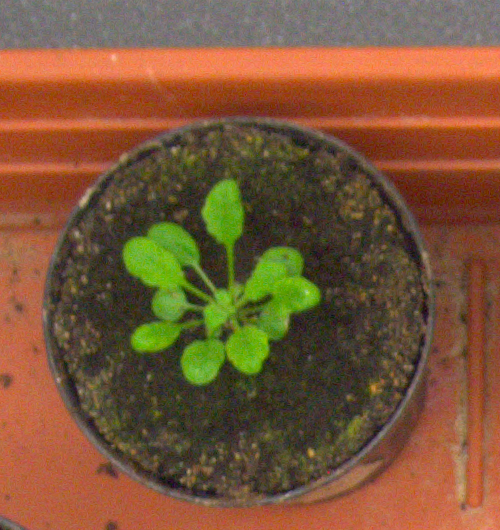

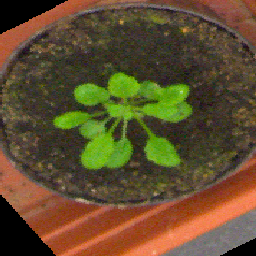

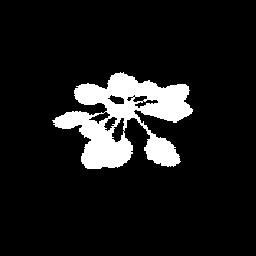

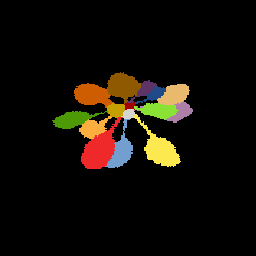

torch.Size([3, 256, 256])
torch.float32
True Cluster Count: 16
15.0
0.0


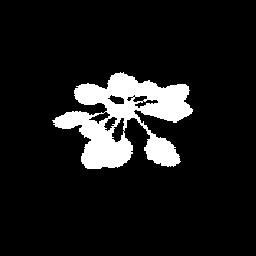

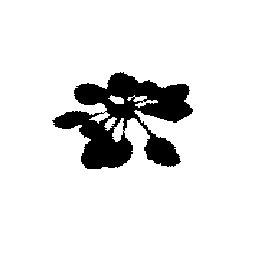

In [ ]:
RGB_INPUT_PATH_LIST = sorted(glob.glob(DATASET_PATH + "A?/plant???*_rgb.png"))
FOREGROUND_FILES = sorted(glob.glob(DATASET_PATH + "*/plant???*_fg.png"))
INSTANCE_LABEL_PATH_LIST = sorted(glob.glob(DATASET_PATH + "A?/plant???*_label.png"))

RGB_INPUTS = [Image.open(filepath).convert("RGB") for filepath in RGB_INPUT_PATH_LIST[:1]]
SEMANTIC_IMAGES = [Image.open(filepath) for filepath in FOREGROUND_FILES[:1]]
INSTANCE_LABELS = [Image.open(filepath).convert("RGB") for filepath in INSTANCE_LABEL_PATH_LIST[:1]]

transforms = T.Compose([
           Resize((256, 256)),
           RandomRotation(),
           RandomScaleDeformation(1.5, 1.5),
           RandomHFlip(),
           ToTensor(),
           Last(),
])

input_dict = {'image': RGB_INPUTS[0], 'sem': SEMANTIC_IMAGES[0], 'colored': INSTANCE_LABELS[0]}

res = transforms(input_dict)

display(RGB_INPUTS[0])
display(F.to_pil_image(res['image']))
display(F.to_pil_image(np.transpose(res['sem'], [1, 2, 0])[:, :, 1]))
display(F.to_pil_image(res['colored']))

print(res['colored'].shape)
print(res['colored'].dtype)
print(f"True Cluster Count: {len(F.to_pil_image(res['colored']).getcolors())}")
print(np.max(np.array(res['ins'])))
print(np.min(np.array(res['ins'])))
display(F.to_pil_image((np.transpose(np.array(res['ins']), [1, 2, 0]) != 0).astype(np.uint8) * 255))
display(F.to_pil_image((np.transpose(np.array(res['ins']), [1, 2, 0]) == 0).astype(np.uint8) * 255))

In [ ]:
cvppp_dataset = CVPPPDataset(DATASET_PATH)
print(f'Dataset total length: {len(cvppp_dataset)} samples')

Train length: 1458 samples
Validation length: 162 samples
Testing length: 162 samples


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Dataset total length: 1782 samples


## Training

### Parameters

In [ ]:
EMBEDDINGS_DIM = 16
NUM_CLASSES = 2
DECODER_ATTENTION = "scse"
DELTA_DIST = 1.5
DELTA_VAR = 0.5

### Early stopping

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### U-Net

In [ ]:
class UnetExpanded(smp.Unet):
    def __init__(self, embeddings_head_dim, *args, **kwargs):
        super(UnetExpanded, self).__init__(*args, **kwargs)
            
        # Add embeddings head
        self.embeddings_head = deepcopy(self.segmentation_head)
        self.embeddings_head[0] = nn.Conv2d(16, embeddings_head_dim, kernel_size=3, padding=1)
        self.embeddings_head[2].activation = nn.Identity()

    def forward(self, x):
        """Sequentially pass `x` trough model`s encoder, decoder and heads"""
        features = self.encoder(x)
        decoder_output = self.decoder(*features)

        masks = self.segmentation_head(decoder_output)

        if self.embeddings_head is not None:
            labels = self.embeddings_head(decoder_output)
            return masks, labels

        return masks

### Discriminative Loss

In [ ]:
"""
This is the implementation of following paper:
https://arxiv.org/pdf/1802.05591.pdf
This implementation is based on following code:
https://github.com/davyneven/fastSceneUnderstanding
"""

class DiscriminativeLoss(_Loss):
    def __init__(self, delta_var=0.5, delta_dist=1.5,
                 norm=2, alpha=1.0, beta=1.0, gamma=0.001,
                 usegpu=True, size_average=True):
        super(DiscriminativeLoss, self).__init__(size_average)
        self.delta_var = delta_var
        self.delta_dist = delta_dist
        self.norm = norm
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.usegpu = usegpu
        assert self.norm in [1, 2]

    def forward(self, prediction, labels):
        """Calculate the loss function value.

        prediction - (batch_size, channels, height, width)
        labels - (batch_size, num_classes, height, width) - each matrix is coded from 0-#Instances - 1 for each
            different instance.
        """
        return self._discriminative_loss(prediction, labels)

    def _discriminative_loss(self, prediction, labels):
        BATCH_SIZE, NUM_CHANNELS, HEIGHT, WIDTH = prediction.size()
        # For each class there is an instance map
        NUM_CLASSES = labels.size(1)

        loss = 0
        # Each image on the batch
        for batch_idx in range(BATCH_SIZE):
            pred = prediction[batch_idx]

            # Each different class (supports multiple classes clustering)
            for class_idx in range(NUM_CLASSES):
                loss_v = 0
                means = []
                # Get current label from instance map
                curr_label = labels[batch_idx, class_idx].contiguous().view(1, HEIGHT, WIDTH)
                num_instances = torch.max(curr_label).int()
                for instance_idx in range(1, num_instances + 1):
                    mask = torch.eq(curr_label, instance_idx)
                    # Only when there are any instances of it
                    if mask.sum() > 0:
                        # Calculate the mean embeddings
                        inst = pred[mask.expand_as(pred)].contiguous().view(NUM_CHANNELS, -1, 1)
                        inst_mean = torch.mean(inst, 1).unsqueeze(2)
                        means.append(inst_mean)

                        # Variance term
                        var = self._norm((inst - inst_mean), 2)
                        var = torch.clamp(var - (self.delta_var), min=0)

                        var = torch.pow(var, 2)
                        var = var.contiguous().view(-1)

                        var = torch.mean(var)
                        loss_v += var

                loss_var = loss_v
    
                # Distance term
                loss_dist = 0
                # This term does not make sense if there is only 1 cluster
                if len(means) > 1:
                    loss_d = 0
                    for mean_idx in range(len(means)):
                        mean_A = means[mean_idx]
                        for next_mean_idx in range(mean_idx + 1, len(means)):
                            mean_B = means[next_mean_idx]
                            d = self._norm(mean_A - mean_B, self.norm)
                            d = torch.pow(torch.clamp(-(d - 2 * self.delta_dist), min=0), 2)
                            loss_d += d[0][0]
                    
                    loss_dist += loss_d / (len(means) - 1 + 1e-8)
    
                # Regularization term
                loss_reg = 0
                for mean in means:
                    loss_reg += self._norm(mean, self.norm)
    
                loss += (loss_var * self.alpha + loss_dist * self.beta + loss_reg * self.gamma) / (len(means) + 1e-8)

        loss = loss / BATCH_SIZE

        return loss

    def _norm(self, inp, level):
        if level == 1:
            return torch.sum(torch.abs(inp), 0)
        else:
            return torch.sqrt(torch.sum(torch.pow(inp, 2), 0) + 1e-8)

### Setup

In [ ]:
# Model
model = UnetExpanded(
    EMBEDDINGS_DIM,
    encoder_name="resnet34",          # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",       # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                    # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=NUM_CLASSES,
    activation="softmax",
    decoder_attention_type=DECODER_ATTENTION).cuda()

print(model)

# Loss Function
criterion_disc = DiscriminativeLoss(delta_var=DELTA_VAR, delta_dist=DELTA_DIST).cuda()
criterion_ce = nn.CrossEntropyLoss().cuda()

# Optimizer
parameters = model.parameters()
optimizer = optim.Adam(parameters, lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=10, verbose=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

UnetExpanded(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


### Training

  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/segmentation_models_pytorch/base/modules.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


Early stopping


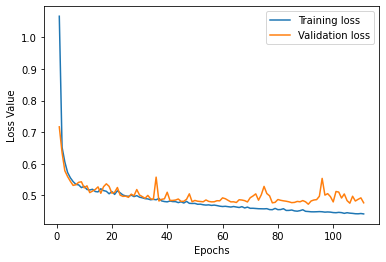

In [ ]:
best_loss = np.inf
MAX_EPOCHS = 300
train_losses_graph = []
valid_losses_graph = []
early_stopping = EarlyStopping(patience=20, verbose=False)

num_epochs = 0
for epoch in tqdm(range(MAX_EPOCHS)):
    valid_losses = []
    disc_losses = []
    ce_losses = []
    
    # Training
    model.train()
    for rgb_input, sem_labels, ins_labels, _ in cvppp_dataset.train_batches:
        rgb_input = Variable(rgb_input).cuda()
        sem_labels = Variable(sem_labels).cuda()
        ins_labels = Variable(ins_labels).cuda()
        model.zero_grad()

        sem_predict, ins_predict = model(rgb_input)
        del rgb_input
       
        loss = 0

        # Discriminative Loss
        disc_loss = criterion_disc(ins_predict, ins_labels)
        del ins_labels
        loss += disc_loss
        disc_losses.append(disc_loss.item())

        # Cross Entropy Loss
        _, sem_labels_ce = sem_labels.max(1)
        del sem_labels
        ce_loss = criterion_ce(sem_predict.permute(0, 2, 3, 1).contiguous().view(-1, 2), sem_labels_ce.view(-1))
        loss += ce_loss
        ce_losses.append(ce_loss.item())

        #with GuruMeditation():
        #    loss.backward()
        loss.backward()
        loss.detach()
        ce_loss.detach()
        disc_loss.detach()
        optimizer.step()

    disc_loss = np.mean(disc_losses)
    ce_loss = np.mean(ce_losses)
    train_losses_graph.append(ce_loss + disc_loss)
    scheduler.step(disc_loss)
    
    # Validation
    model.eval()
    for rgb_input, sem_labels, ins_labels, _ in cvppp_dataset.val_batches:
        rgb_input = Variable(rgb_input).cuda()
        sem_labels = Variable(sem_labels).cuda()
        ins_labels = Variable(ins_labels).cuda()
 
        # forward pass: compute predicted outputs by passing inputs to the model
        sem_predict, ins_predict = model(rgb_input)
        del rgb_input
        # calculate the loss
        disc_loss = criterion_disc(ins_predict, ins_labels)
        del ins_labels
        loss = disc_loss
        _, sem_labels_ce = sem_labels.max(1)
        del sem_labels
        ce_loss = criterion_ce(sem_predict.permute(0, 2, 3, 1).contiguous().view(-1, 2), sem_labels_ce.view(-1))
        loss += ce_loss
        # record validation loss
        valid_losses.append(loss.cpu().data.numpy())
        loss.detach()
        ce_loss.detach()
        disc_loss.detach()

    valid_loss = np.average(valid_losses)
    valid_losses_graph.append(valid_loss)

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_loss, model)
    
    num_epochs += 1
    if early_stopping.early_stop:
        print("Early stopping")
        break
   
plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), train_losses_graph, label="Training loss")   
plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), valid_losses_graph, label="Validation loss")   
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend(loc="upper right")
plt.show()

## Inference

In [ ]:
# Model
model = UnetExpanded(
    EMBEDDINGS_DIM,
    encoder_name="resnet34",          # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",       # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                    # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=NUM_CLASSES,
    activation="softmax",
    decoder_attention_type=DECODER_ATTENTION).cuda()

model.eval()

model_path = Path('./checkpoint.pt')

param = torch.load(model_path)
model.load_state_dict(param)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
# Input
input_images = []

# Ground truths
gt = []
sem_gt = []

# Outputs
sem_pred = []
ins_pred = []

# Predict on test set
for rgb, sem_label, _, colored_labels in cvppp_dataset.test_batches:
    input_images.append(rgb.numpy())
    sem_gt.append(sem_label.numpy())
    [gt.append(i) for i in colored_labels]

    with torch.no_grad():
        images_ = Variable(rgb).cuda()
        sem_pred_, ins_pred_ = model(images_)
        del images_
        sem_pred.append(sem_pred_.cpu().numpy())
        ins_pred.append(ins_pred_.cpu().numpy())
    
input_images = np.concatenate(input_images)
sem_gt = np.concatenate(sem_gt)[:, 1, :, :]
sem_pred = np.concatenate(sem_pred)[:, 1, :, :]
ins_pred = np.concatenate(ins_pred)

# Post Processing
p_sem_pred = []
for sp in sem_pred:
    p_sem_pred.append(sp > 0.5)

/usr/local/lib/python3.7/dist-packages/segmentation_models_pytorch/base/modules.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


### Visualization

In [ ]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


def create_color_image(sem_pred, labels):
    num_clusters = np.max(labels)

    cmap = get_cmap(num_clusters)
    instance_mask = np.zeros_like(sem_pred, dtype=np.uint8)
    for i in range(num_clusters + 1):
        lbl = np.zeros_like(labels, dtype=np.uint8)
        lbl[labels == i] = i + 1
        instance_mask[sem_pred] += lbl
    
    ins_color_img = np.zeros((instance_mask.shape[0], instance_mask.shape[1], 3), dtype=float)
    for i in range(num_clusters + 1):
        ins_color_img[instance_mask == i + 1] = np.array(cmap(i)[:3])
 
    return ins_color_img


def denormalize_input(input):
    output = np.zeros_like(input, dtype=float)
    for i in [0, 1, 2]:
        output[:, :, i] = (input[:, :, i] * cvppp_dataset.test_stds[i]) + cvppp_dataset.test_means[i]  

    return output

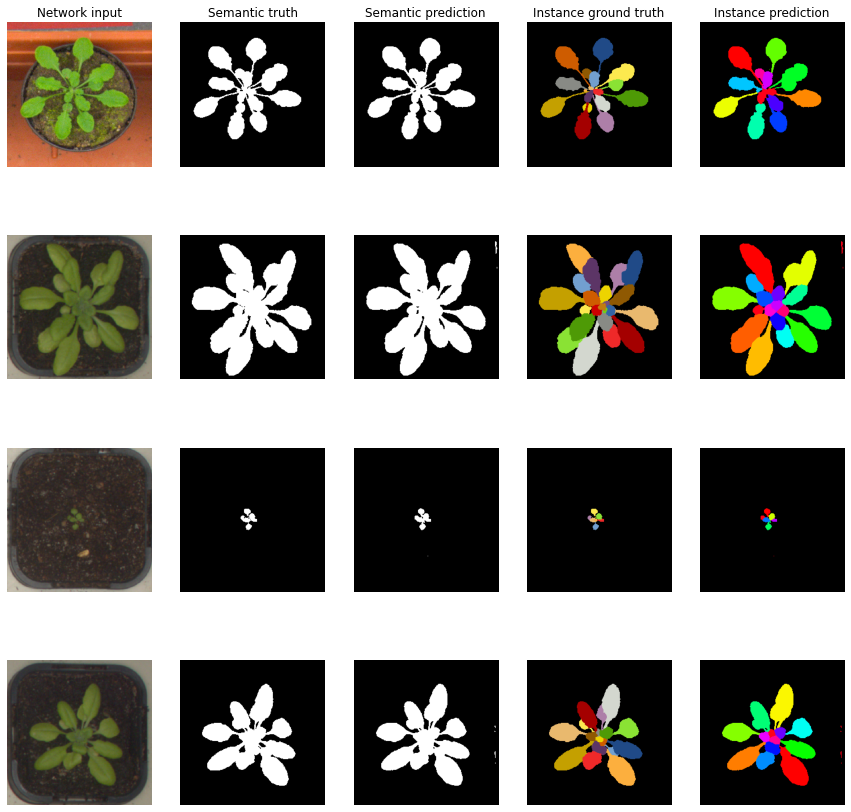

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(15, 15))

axes[0][0].set_title("Network input")
axes[0][1].set_title("Semantic truth")
axes[0][2].set_title("Semantic prediction")
axes[0][3].set_title("Instance ground truth")
axes[0][4].set_title("Instance prediction")
shift = 15

mean_shift_labels = []
masked_predictions = []
for i, ax_ in enumerate(axes):
    SAMPLE_NUM = shift + i

    ax_[0].set_axis_off()
    ax_[1].set_axis_off()
    ax_[2].set_axis_off()
    ax_[3].set_axis_off()
    ax_[4].set_axis_off()

    ax_[0].imshow(denormalize_input(np.transpose(input_images[SAMPLE_NUM], [1, 2, 0])))
    ax_[1].imshow(sem_gt[SAMPLE_NUM], cmap="gray")
    ax_[2].imshow(p_sem_pred[SAMPLE_NUM].squeeze(), cmap="gray")
    ax_[3].imshow(np.transpose(gt[SAMPLE_NUM], [1, 2, 0]))
    
    # Applies semantic mask on instance prediction
    masked_instance_prediction = ins_pred[SAMPLE_NUM, :, p_sem_pred[SAMPLE_NUM]]
    masked_predictions.append(masked_instance_prediction)
    
    # Cluster
    mean_shift_clusterer = MeanShift(bandwidth=DELTA_DIST).fit(masked_instance_prediction)
    mean_shift_cluster_labels = mean_shift_clusterer.labels_
    mean_shift_labels.append(mean_shift_cluster_labels)

    color_img_mean = create_color_image(p_sem_pred[SAMPLE_NUM], mean_shift_cluster_labels)
    ax_[4].imshow(color_img_mean)

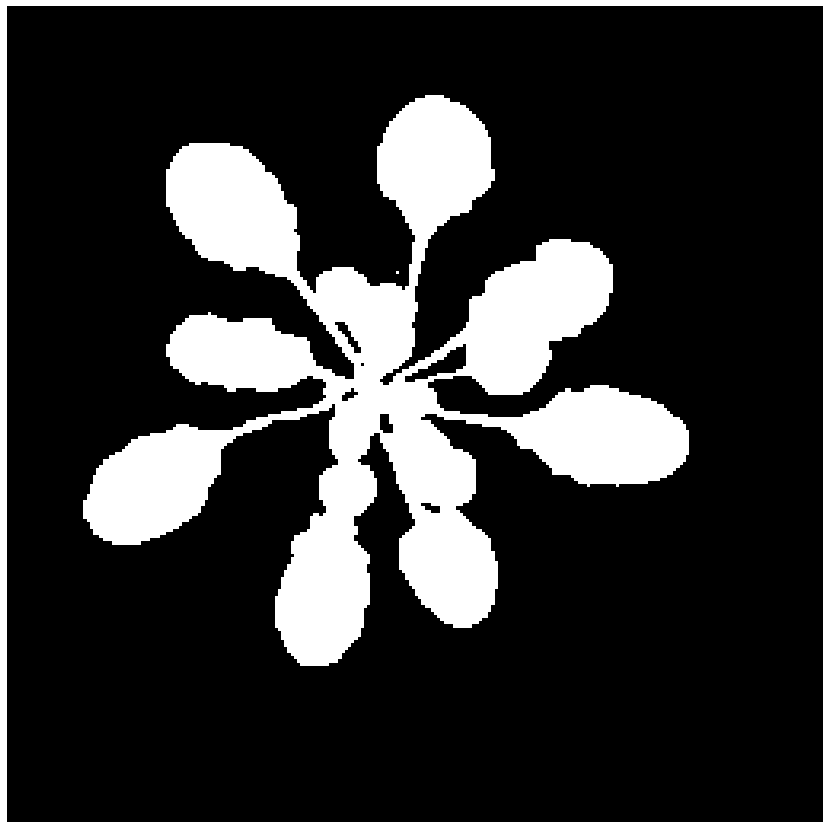

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(15, 15))
axes.set_axis_off()
#axes[1].set_axis_off()
#axes.set_title("Predicted")
#axes[1].set_title("Binarized")
axes.imshow(p_sem_pred[15], cmap='gray')
#axes[1].imshow(p_sem_pred[15], cmap='gray')

### Cluster Visualization

In [ ]:
def plot_clusters_2d_embeddings():
    if masked_predictions[0].shape[1] == 2:
        # initialize a matplotlib plot
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
        ax.set_axis_off()
        labels = mean_shift_labels[0]
        ax.set_title("Mean Shift")

        # Plot each cluster separatelly with a different color
        num_clusters = np.max(labels) + 1
        COLOR_MAP = get_cmap(num_clusters)
        
        for CLUSTER in range(num_clusters + 1):
            # Get indices of points of that cluster
            indices = (labels == CLUSTER).nonzero()
            # Retrieve the correct elements
            cluster_elements = np.take(masked_predictions[0], indices, axis=0)
            # Plot
            ax.scatter(cluster_elements[:, :, 0], cluster_elements[:, :, 1],
                    color=COLOR_MAP(CLUSTER), label=CLUSTER)
        
        # build a legend using the labels we set previously
        ax.legend(loc='right')
    
        fig.tight_layout()
        # finally, show the plot
        plt.show()

plot_clusters_2d_embeddings()

### Result exporter

In [ ]:
def cvppp_dataset_path_create(output_folder, gt_file):
    folder = os.path.join(output_folder, gt_file.split('/')[-2])
    file_name = gt_file.split('/')[-1].split('_')[-2] + ".png"

    return folder, file_name


def cvppp_dataset_prediction_image(i):
    # Cluster
    masked_instance_prediction = ins_pred[i, :, p_sem_pred[i]]
    #k_means_clusterer = KMeans(int(cc[i])).fit(masked_instance_prediction)
    mean_shift_clusterer = MeanShift(bandwidth=DELTA_DIST).fit(masked_instance_prediction)
    #k_means_cluster_labels = k_means_clusterer.labels_
    labels = mean_shift_clusterer.labels_
    #color_img_k = create_color_image(p_sem_pred[i], k_means_cluster_labels)
    color_img = create_id_image(p_sem_pred[i], labels)

    return color_img

In [ ]:
def create_id_image(sem_pred, labels):
    num_clusters = np.max(labels)

    cmap = get_cmap(num_clusters)
    instance_mask = np.zeros_like(sem_pred, dtype=np.uint8)
    for i in range(num_clusters + 1):
        lbl = np.zeros_like(labels, dtype=np.uint8)
        lbl[labels == i] = i + 1
        instance_mask[sem_pred] += lbl
    
    ins_color_img = np.zeros((instance_mask.shape[0], instance_mask.shape[1]), dtype=np.uint8)
    for i in range(num_clusters + 1):
        ins_color_img[instance_mask == i + 1] = i + 1
 
    return ins_color_img


def predictions_export(dataset, image_creation_f, path_creation_f, output_folder, transformed_input_folder, test_files):
    # Save processed dataset images
    for i in tqdm(range(len(test_files))):
        gt_file = test_files[i]

        folder, file_name = path_creation_f(output_folder, gt_file)
        input_folder, _ = path_creation_f(transformed_input_folder, gt_file)
        id_img = image_creation_f(i)

        if not os.path.exists(folder):
            os.makedirs(folder)

        if not os.path.exists(input_folder):
            os.makedirs(input_folder)

        gt_im = F.to_pil_image(gt[i])
        gt_im.convert('P', palette=Image.ADAPTIVE).save(os.path.join(input_folder, file_name))
        Image.fromarray(id_img).save(os.path.join(folder, file_name))

In [ ]:
cvppp_test_files = [cvppp_dataset.RGB_INPUT_PATH_LIST[i] for i in cvppp_dataset.test_indices]
predictions_export(cvppp_dataset, cvppp_dataset_prediction_image, cvppp_dataset_path_create, "./predictions/", "./gts/", cvppp_test_files)

  0%|          | 0/162 [00:00<?, ?it/s]

In [ ]:
!zip -r ./predictions.zip ./predictions/
!zip -r ./gts.zip ./gts/

  adding: predictions/ (stored 0%)
  adding: predictions/A1/ (stored 0%)
  adding: predictions/A1/plant113.png (deflated 1%)
  adding: predictions/A1/plant024.png (deflated 1%)
  adding: predictions/A1/plant005.png (deflated 2%)
  adding: predictions/A1/plant128.png (deflated 1%)
  adding: predictions/A1/plant022.png (deflated 1%)
  adding: predictions/A1/plant016.png (deflated 1%)
  adding: predictions/A1/plant044.png (deflated 1%)
  adding: predictions/A1/plant026.png (deflated 1%)
  adding: predictions/A1/plant145.png (deflated 1%)
  adding: predictions/A1/plant138.png (deflated 1%)
  adding: predictions/A1/plant088.png (deflated 1%)
  adding: predictions/A1/plant038.png (deflated 1%)
  adding: predictions/A1/plant083.png (deflated 1%)
  adding: predictions/A1/plant039.png (deflated 1%)
  adding: predictions/A1/plant130.png (deflated 1%)
  adding: predictions/A1/plant129.png (deflated 1%)
  adding: predictions/A1/plant153.png (deflated 1%)
  adding: predictions/A1/plant133.png (defl

In [ ]:
experiment_folder = os.path.join("/content/drive/My Drive/TCC/", "experiment_" + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') \
                                 + f'_{EMBEDDINGS_DIM}d_{DECODER_ATTENTION}_cvppp/')

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

shutil.copyfile("./checkpoint.pt", os.path.join(experiment_folder, "checkpoint.pt"))
shutil.copyfile("./predictions.zip", os.path.join(experiment_folder, "predictions.zip"))
shutil.copyfile("./gts.zip", os.path.join(experiment_folder, "gts.zip"))

'/content/drive/My Drive/TCC/experiment_2022-04-28_04-56-00_16d_scse_cvppp/gts.zip'